# Promotion Targetting with Logistic Regression

## Context

A business organisation developed a new product and decided to market it to existing customers of the organization. At the first stage, they decided to contact a sample of the customers. This promotional program is completed and the response information along with profile of the customers is available in the dataset. The organization is interested in using this information to select the best customers from the rest of the customer pool so that promotion cost can be reduced.

The Analytics approach is to build a model using the available information from the completed campaign. This model will be applied to the target datset (the customers not contacted) to select the customers so that profit is maximised.

#### Note: This is an altered rework of the original notebook hosted here: https://www.kaggle.com/regivm/response-model-development-and-implementation/notebook by Kaggle user Regi. Please visit the link for more info.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

df = pd.read_csv('promoted.csv')

In [2]:
df.head(5)

,customer_id,resp,card_tenure,risk_score,num_promoted,avg_bal,geo_group,res_type
0,SB0000024239,0,143.0,520,0,4108.0,E,TO
1,SB0000103256,0,91.0,694,0,3268.0,N,CO
2,SB0000115357,0,139.0,520,0,3785.0,E,NaN
3,SB0000060380,0,147.0,676,0,3402.0,E,CO
4,SB0000138548,0,222.0,717,0,3580.0,SE,CO


The variable definitions are as follows:



resp: Responded or not (1=yes, 0=no) 

card_tenure: Card Tenure in months 

risk_score: Risk Score 

num_promoted: Number of times customer was contacted earlier for the same product 

avg_bal: Average balance 

geo_group: Geographical Group (NW W, S, E, SE) 

res_type: Residence Type (SI=single family, CO=cooperative, CN=condominium, RE=rental, TO=townhouse)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 8 columns):
customer_id     25000 non-null object
resp            25000 non-null int64
card_tenure     24515 non-null float64
risk_score      25000 non-null int64
num_promoted    25000 non-null int64
avg_bal         24286 non-null float64
geo_group       24491 non-null object
res_type        24016 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 1.5+ MB


In [4]:
df.describe()

,resp,card_tenure,risk_score,num_promoted,avg_bal
count,25000.000000,24515.000000,25000.000000,25000.000000,24286.000000
mean,0.068640,139.491617,655.091680,0.007000,3065.417195
std,0.252846,66.998010,81.315116,0.083374,999.102540
min,0.000000,0.000000,520.000000,0.000000,-132.000000
25%,0.000000,95.000000,599.000000,0.000000,2666.000000
50%,0.000000,135.000000,677.000000,0.000000,3238.000000
75%,0.000000,179.000000,719.000000,0.000000,3632.000000
max,1.000000,641.000000,760.000000,1.000000,10725.000000


This data needs some prep since there are missing values. For the numerical values, let's impute the means since the amount of missing data is small.

In [5]:
df['card_tenure'].fillna(df['card_tenure'].mean(), inplace=True)

In [6]:
df['avg_bal'].fillna(df['avg_bal'].mean(), inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 8 columns):
customer_id     25000 non-null object
resp            25000 non-null int64
card_tenure     25000 non-null float64
risk_score      25000 non-null int64
num_promoted    25000 non-null int64
avg_bal         25000 non-null float64
geo_group       24491 non-null object
res_type        24016 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 1.5+ MB


For categorical variables, let's use the most common category, again since the amount missing is a small percentage.

In [8]:
df['geo_group'].value_counts(dropna=False)

E      10939
N       6446
W       3681
SE      3425
NaN      509
Name: geo_group, dtype: int64

In [9]:
df['res_type'].value_counts(dropna=False)

CO     9400
SI     5425
TO     5010
CN     2453
RE     1728
NaN     984
Name: res_type, dtype: int64

In [10]:
df['geo_group'].fillna('E', inplace=True)

In [11]:
df['res_type'].fillna('CO', inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 8 columns):
customer_id     25000 non-null object
resp            25000 non-null int64
card_tenure     25000 non-null float64
risk_score      25000 non-null int64
num_promoted    25000 non-null int64
avg_bal         25000 non-null float64
geo_group       25000 non-null object
res_type        25000 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 1.5+ MB


Looks like the data is now full. Let's create dummies on our categorical data so our model will be able to use these values.

In [13]:
dfg=pd.get_dummies(df['geo_group'], prefix='geo', drop_first=True)
dfr=pd.get_dummies(df['res_type'], prefix='res', drop_first=True)
dfrg=df.join([dfg,dfr])
dfrg.drop(['geo_group', 'res_type'], axis=1, inplace=True)
df = dfrg
df.head()

,customer_id,resp,card_tenure,risk_score,num_promoted,avg_bal,geo_N,geo_SE,geo_W,res_CO,res_RE,res_SI,res_TO
0,SB0000024239,0,143.0,520,0,4108.0,0,0,0,0,0,0,1
1,SB0000103256,0,91.0,694,0,3268.0,1,0,0,1,0,0,0
2,SB0000115357,0,139.0,520,0,3785.0,0,0,0,1,0,0,0
3,SB0000060380,0,147.0,676,0,3402.0,0,0,0,1,0,0,0
4,SB0000138548,0,222.0,717,0,3580.0,0,1,0,1,0,0,0


Let's define and split our X and y values for training and testing.

In [14]:
X=df.iloc[:, 2:]
y=df['resp']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

We'll use a logistic regression model to classify responders vs non-responders.

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
logmod = LogisticRegression()

In [18]:
logmod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
logpreds = logmod.predict(X_test)

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
print(confusion_matrix(y_test, logpreds))
print(classification_report(y_test, logpreds))

[[7017    0]
 [ 483    0]]
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      7017
          1       0.00      0.00      0.00       483

avg / total       0.88      0.94      0.90      7500



C:\Users\Drew\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Looks like the model isn't predicting responders at all. This is because the highest probability of someone responding must still be below a 50% probability, since the model is highly unbalanced.

In [22]:
logmod.score(X_test, y_test)

0.9356

This score looks decent, but it's a trap. This is simply the percentage of non-responders in the data. Since the model is predicting everyone as a non-responder, it is accurate this often.

Let's change our strategy here. Instead, let's determine who has the highest probability of responding, and decide which percentage of these people we should target based on profit maximization.

In [23]:
prb=logmod.predict_proba(X_train)[:,1]
type(prb)

numpy.ndarray

In [24]:
df = pd.DataFrame({'prob':prb, 'y':y_train})

In [25]:
df=df.sort_values('prob', ascending=False)
df = df.reset_index()
df['new_id']=df.index
df.head(10)

,index,prob,y,new_id
0,22194,0.356333,0,0
1,10568,0.309614,1,1
2,7258,0.270131,0,2
3,12581,0.265288,0,3
4,15025,0.259695,0,4
5,1937,0.242492,0,5
6,20276,0.240228,0,6
7,9172,0.237242,0,7
8,19932,0.235632,0,8
9,14947,0.234161,0,9


We will now calculate cumulative proportion of responders and cumulative proportion of contacts. This will be used to calculate maximum separation (ks max) and proportion at which this occurs.

In [26]:
df['cum_y'] = df.y.cumsum()
df.head(10)

,index,prob,y,new_id,cum_y
0,22194,0.356333,0,0,0
1,10568,0.309614,1,1,1
2,7258,0.270131,0,2,1
3,12581,0.265288,0,3,1
4,15025,0.259695,0,4,1
5,1937,0.242492,0,5,1
6,20276,0.240228,0,6,1
7,9172,0.237242,0,7,1
8,19932,0.235632,0,8,1
9,14947,0.234161,0,9,1


In [27]:
df['cumy_perc'] = 100*df.cum_y/df.y.sum()
df.head(10)

,index,prob,y,new_id,cum_y,cumy_perc
0,22194,0.356333,0,0,0,0.000000
1,10568,0.309614,1,1,1,0.081103
2,7258,0.270131,0,2,1,0.081103
3,12581,0.265288,0,3,1,0.081103
4,15025,0.259695,0,4,1,0.081103
5,1937,0.242492,0,5,1,0.081103
6,20276,0.240228,0,6,1,0.081103
7,9172,0.237242,0,7,1,0.081103
8,19932,0.235632,0,8,1,0.081103
9,14947,0.234161,0,9,1,0.081103


In [28]:
df['pop_perc'] = 100*df.new_id/df.new_id.max()
df.head(10)

,index,prob,y,new_id,cum_y,cumy_perc,pop_perc
0,22194,0.356333,0,0,0,0.000000,0.000000
1,10568,0.309614,1,1,1,0.081103,0.005715
2,7258,0.270131,0,2,1,0.081103,0.011429
3,12581,0.265288,0,3,1,0.081103,0.017144
4,15025,0.259695,0,4,1,0.081103,0.022858
5,1937,0.242492,0,5,1,0.081103,0.028573
6,20276,0.240228,0,6,1,0.081103,0.034288
7,9172,0.237242,0,7,1,0.081103,0.040002
8,19932,0.235632,0,8,1,0.081103,0.045717
9,14947,0.234161,0,9,1,0.081103,0.051432


In [29]:
df['ks_value']=df['cumy_perc'] - df['pop_perc']
df.head(10)

,index,prob,y,new_id,cum_y,cumy_perc,pop_perc,ks_value
0,22194,0.356333,0,0,0,0.000000,0.000000,0.000000
1,10568,0.309614,1,1,1,0.081103,0.005715,0.075388
2,7258,0.270131,0,2,1,0.081103,0.011429,0.069674
3,12581,0.265288,0,3,1,0.081103,0.017144,0.063959
4,15025,0.259695,0,4,1,0.081103,0.022858,0.058245
5,1937,0.242492,0,5,1,0.081103,0.028573,0.052530
6,20276,0.240228,0,6,1,0.081103,0.034288,0.046815
7,9172,0.237242,0,7,1,0.081103,0.040002,0.041101
8,19932,0.235632,0,8,1,0.081103,0.045717,0.035386
9,14947,0.234161,0,9,1,0.081103,0.051432,0.029671


In [30]:
ksmax = df['ks_value'].max()
print(ksmax)
max_pop = df[df['ks_value'] == df['ks_value'].max()]['pop_perc'].item()
print(max_pop)

20.27918453178207
45.819761129207386


In [31]:
df.tail()

,index,prob,y,new_id,cum_y,cumy_perc,pop_perc,ks_value
17495,13248,0.000953,0,17495,1233,100.0,99.977142,0.022858
17496,1428,0.000934,0,17496,1233,100.0,99.982856,0.017144
17497,15536,0.000926,0,17497,1233,100.0,99.988571,0.011429
17498,12207,0.000916,0,17498,1233,100.0,99.994285,0.005715
17499,10716,0.000835,0,17499,1233,100.0,100.000000,0.000000


Let's get a visual of all this.

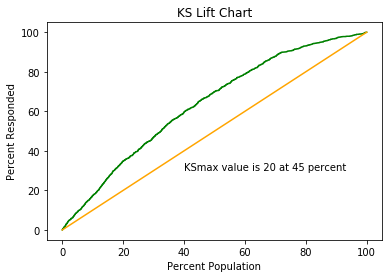

In [32]:
plt.plot(df.pop_perc, df.cumy_perc, color='g')
plt.plot(df.pop_perc, df.pop_perc, color='orange')
plt.xlabel('Percent Population')
plt.ylabel('Percent Responded')
#plt.title('KS Lift Chart')
plt.text(40, 30, 'KSmax value is %d at %d percent' %(ksmax, max_pop))
plt.title('KS Lift Chart')
plt.show()

Great. Now let's determine profit maximization. Let's assume each new responder generates 3,500 in revenue, and the cost for each person targetted is 250.

In [33]:
revenue=3500
cost=250
df['profit'] = df['cum_y']*3500 - df['new_id']*250
max_pop =df.loc[df['profit'] == df['profit'].max(), 'pop_perc'].item()
prmax=df['profit'].max()
df.head(3)

,index,prob,y,new_id,cum_y,cumy_perc,pop_perc,ks_value,profit
0,22194,0.356333,0,0,0,0.000000,0.000000,0.000000,0
1,10568,0.309614,1,1,1,0.081103,0.005715,0.075388,3250
2,7258,0.270131,0,2,1,0.081103,0.011429,0.069674,3000


In [34]:
print(max_pop)
print(prmax)

45.819761129207386
848000


We now have the percentage of people we should target to maximize profit. We can visualize this too.

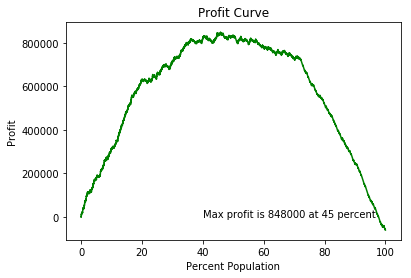

In [35]:
plt.plot(df.pop_perc, df.profit, color='g')
#plt.plot(df.pop_perc, df.pop_perc, color='orange')
plt.xlabel('Percent Population')
plt.ylabel('Profit')
#plt.title('KS Lift Chart')
plt.text(40, 30, 'Max profit is %d at %d percent' %(prmax, max_pop))
plt.title('Profit Curve')
plt.show()

In [36]:
dft=pd.read_csv('target.csv')

In [37]:
dft.describe()

,card_tenure,risk_score,num_promoted,avg_bal,Unnamed: 7
count,107792.000000,110000.000000,110000.000000,106771.000000,0.0
mean,138.956564,655.571482,0.006782,3067.702194,NaN
std,67.433081,81.252328,0.082183,1036.418148,NaN
min,12.000000,520.000000,0.000000,-132.000000,NaN
25%,91.000000,600.000000,0.000000,2652.000000,NaN
50%,135.000000,678.000000,0.000000,3240.000000,NaN
75%,179.000000,720.000000,0.000000,3636.000000,NaN
max,641.000000,760.000000,2.000000,10775.000000,NaN


Looks like there's a null field being read. Let's drop this so it doesn't interfere.

In [38]:
dft.drop('Unnamed: 7', axis=1, inplace=True)

In [39]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110000 entries, 0 to 109999
Data columns (total 7 columns):
customer_id     110000 non-null object
card_tenure     107792 non-null float64
risk_score      110000 non-null int64
num_promoted    110000 non-null int64
avg_bal         106771 non-null float64
geo_group       107787 non-null object
res_type        105651 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 5.9+ MB


We'll use the same prep methods that we used above on the training data for consistency.

In [40]:
dft['card_tenure'].fillna(dft['card_tenure'].mean(), inplace=True)
dft['avg_bal'].fillna(dft['avg_bal'].mean(), inplace=True)
dft.describe()

,card_tenure,risk_score,num_promoted,avg_bal
count,110000.000000,110000.000000,110000.000000,110000.000000
mean,138.956564,655.571482,0.006782,3067.702194
std,66.752861,81.252328,0.082183,1021.092913
min,12.000000,520.000000,0.000000,-132.000000
25%,95.000000,600.000000,0.000000,2679.000000
50%,135.000000,678.000000,0.000000,3233.000000
75%,179.000000,720.000000,0.000000,3624.000000
max,641.000000,760.000000,2.000000,10775.000000


In [41]:
dft['geo_group'].value_counts(dropna=False)

E      47734
N      28342
W      16761
SE     14950
NaN     2213
Name: geo_group, dtype: int64

In [42]:
dft['res_type'].value_counts(dropna=False)

CO     41600
SI     23970
TO     21864
CN     10807
RE      7410
NaN     4349
Name: res_type, dtype: int64

In [43]:
dft['geo_group'].fillna('E', inplace=True)
dft['res_type'].fillna('CO', inplace=True)

In [44]:
dfg=pd.get_dummies(dft['geo_group'], prefix='geo', drop_first=True)
dfr=pd.get_dummies(dft['res_type'], prefix='res', drop_first=True)
dfrg=dft.join([dfg,dfr])
dfrg.drop(['geo_group', 'res_type'], axis=1, inplace=True)
dft=dfrg
dft.head(3)

,customer_id,card_tenure,risk_score,num_promoted,avg_bal,geo_N,geo_SE,geo_W,res_CO,res_RE,res_SI,res_TO
0,SB0000057824,198.0,755,0,3818.0,0,0,0,1,0,0,0
1,SB0000030501,206.0,647,0,3357.0,0,1,0,0,0,0,0
2,SB0000082532,107.0,629,0,3728.0,1,0,0,0,0,0,0


Let's rename this data Xt for X test.

In [45]:
Xt=dft.drop('customer_id', axis=1)
Xt.head()

,card_tenure,risk_score,num_promoted,avg_bal,geo_N,geo_SE,geo_W,res_CO,res_RE,res_SI,res_TO
0,198.0,755,0,3818.0,0,0,0,1,0,0,0
1,206.0,647,0,3357.0,0,1,0,0,0,0,0
2,107.0,629,0,3728.0,1,0,0,0,0,0,0
3,36.0,663,0,3110.0,0,0,1,1,0,0,0
4,210.0,695,0,1900.0,0,1,0,1,0,0,0


In [46]:
Xt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110000 entries, 0 to 109999
Data columns (total 11 columns):
card_tenure     110000 non-null float64
risk_score      110000 non-null int64
num_promoted    110000 non-null int64
avg_bal         110000 non-null float64
geo_N           110000 non-null uint8
geo_SE          110000 non-null uint8
geo_W           110000 non-null uint8
res_CO          110000 non-null uint8
res_RE          110000 non-null uint8
res_SI          110000 non-null uint8
res_TO          110000 non-null uint8
dtypes: float64(2), int64(2), uint8(7)
memory usage: 4.1 MB


In [47]:
Xt.describe()

,card_tenure,risk_score,num_promoted,avg_bal,geo_N,geo_SE,geo_W,res_CO,res_RE,res_SI,res_TO
count,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000
mean,138.956564,655.571482,0.006782,3067.702194,0.257655,0.135909,0.152373,0.417718,0.067364,0.217909,0.198764
std,66.752861,81.252328,0.082183,1021.092913,0.437345,0.342694,0.359383,0.493185,0.250652,0.412827,0.399072
min,12.000000,520.000000,0.000000,-132.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,95.000000,600.000000,0.000000,2679.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,135.000000,678.000000,0.000000,3233.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,179.000000,720.000000,0.000000,3624.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,641.000000,760.000000,2.000000,10775.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's take a list of the customer IDs so we can add this to the data later to know which customers to target. We'll run the Xt data through the model then create a dataframe with the customer IDs attached.

In [48]:
cid=dft['customer_id']

In [49]:
prb=logmod.predict_proba(Xt)[:,1]
tgt=pd.DataFrame({'resp_prob':prb, 'customer_id':cid })
tgt.sort_values('resp_prob', ascending=False, inplace=True)
tgt['tgt_num'] = range(len(tgt))
tgt['tgt_perc'] = 100*tgt.tgt_num/(tgt.tgt_num.max())
tgt.head(3)

,customer_id,resp_prob,tgt_num,tgt_perc
103238,SB0000019203,0.353998,0,0.000000
22120,SB0000134999,0.329570,1,0.000909
50898,SB0000055838,0.327954,2,0.001818


Now we select the appropriate top percentage of potential responders for profit maximization.

In [50]:
target=tgt[tgt['tgt_perc']<=max_pop]
target.head()

,customer_id,resp_prob,tgt_num,tgt_perc
103238,SB0000019203,0.353998,0,0.000000
22120,SB0000134999,0.329570,1,0.000909
50898,SB0000055838,0.327954,2,0.001818
40608,SB0000040134,0.317346,3,0.002727
76016,SB0000134864,0.316242,4,0.003636


In [51]:
target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50402 entries, 103238 to 50360
Data columns (total 4 columns):
customer_id    50402 non-null object
resp_prob      50402 non-null float64
tgt_num        50402 non-null int32
tgt_perc       50402 non-null float64
dtypes: float64(2), int32(1), object(1)
memory usage: 1.7+ MB


We now have a list of the customers that should be targeted for profit maximization.